# Решение Ad hoc задач в сервисе Яндекс Книги

**Работа с данными бизнеса в ClickHouse**

Дата: 30.10.2025

## Описание задачи

У продакт-менеджера сервиса **Яндекс Книги** накопились ad hoc задачи по аналитике. Они посвящены основным метрикам и паттернам использования сервиса.
Нужно проанализировать в основном мобильные платформы 'Букмейт iOS' и 'Букмейт Android', а в некоторых случаях и 'Букмейт Web', если это явно указано.

Основной инструмент решения задач — **ClickHouse**. Работаем  с двумя таблицами — **source_db.audition** и **source_db.content**.

## Структура


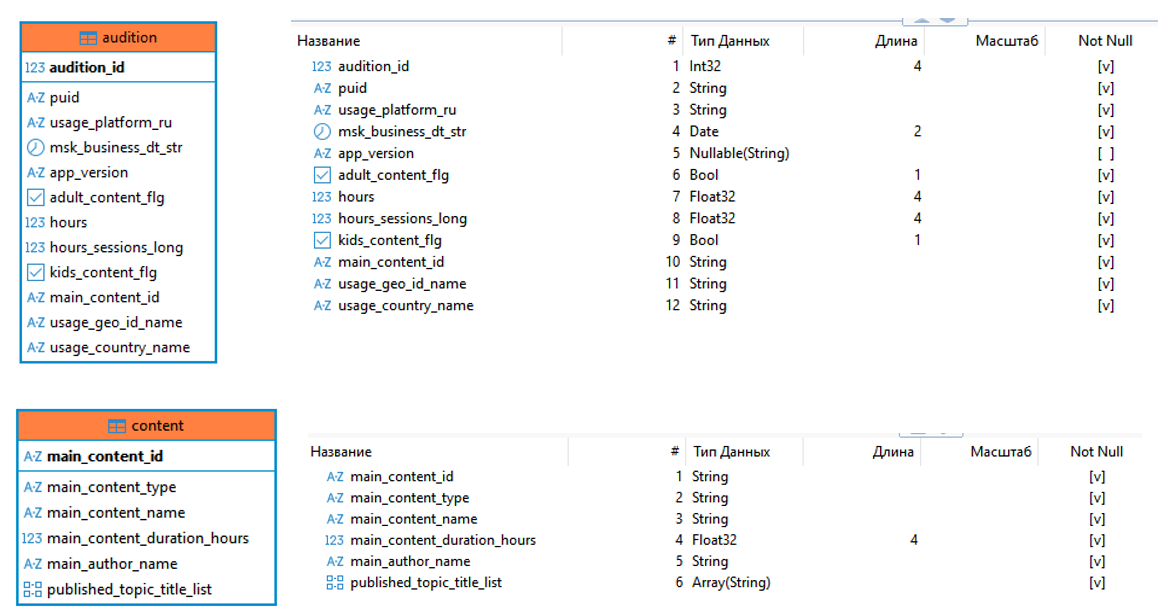

## Задание 1

Где сервис пользуется наибольшей популярностью? Вывести топ-20 городов и регионов России по суммарному количеству прочитанных и прослушанных часов любого контента с мобильных устройств. Для каждой из платформ — iOS и Android — добавьте отдельный столбец с длительностью. 

Результат должен выглядеть так: 
- город, 
- общая длительность прочитанного и прослушанного контента,
- длительность на iOS,
- длительность на Android. 
Значения округлите до целых чисел для лучшей читаемости. 

Из выдачи также исключите федеральные округа — оставьте только города и области.

**Решение:**

In [ ]:
with (select array('Букмейт Android', 'Букмейт iOS')) as array_platform
select  usage_geo_id_name as region,
        sum(hours)::Int32 as duration,
        sumIf(hours, usage_platform_ru like '%iOS%')::Int32 as duration_iOS,
        sumIf(hours, usage_platform_ru like '%Android%')::Int32 as duration_Android
from source_db.audition  
where usage_country_name like 'Россия' and region not like '%федеральный округ%' and has(array_platform, usage_platform_ru)
group by region
order by duration desc
limit 20;

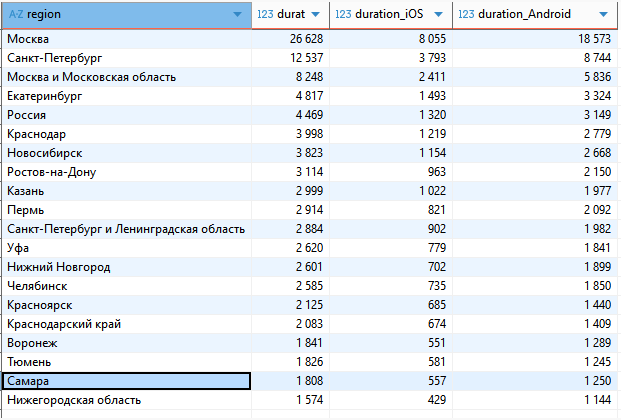

## Задание 2

Какой контент самый популярный? Получите топ-5 книг по суммарному количеству прочитанных и прослушанных часов на мобильных платформах. Также вычислите среднее время чтения и прослушивания в зависимости от типа книги: текст или аудио. 

Результат должен выглядеть так:
- название книги, 
- её автор, 
- суммарное время чтения и прослушивания, 
- среднее время чтения текстовой книги,
- среднее время прослушивания аудиокниги.

В список включайте только те книги, которые используются в обоих форматах. Числовые значения округляйте до двух знаков после точки.

**Решение:**

Порядок такой: сначала выбираем все аудио-книги, затем текстовые, затем по совпадению автора и названия оставляем только те книги, которые есть в обоих форматах. Затем выбираем из таблицы с контентом нужные книги, добавляя первичный ключ. Далее, выполняем основной запрос.

In [ ]:
with (select array('Букмейт Android', 'Букмейт iOS')) as array_platform,
    txt_books as   (select  main_content_name,
                            main_author_name
                    from source_db.content 
                    where main_content_type='Book'),
    audio_books as  (select  main_content_name,
                             main_author_name
                    from source_db.content 
                    where main_content_type='Audiobook'),
    list_books as   (select *
                    from txt_books
                    intersect
                    select * 
                    from audio_books),
    content_selection as    (select * 
                            from source_db.content as c
                            where c.main_content_name in (select main_content_name from list_books) and
                            c.main_author_name in (select main_author_name from list_books) and
                            (c.main_content_type='Audiobook' or c.main_content_type='Book'))
select  c.main_content_name as name,
        c.main_author_name as author,
        round(sum(au.hours), 2) as duration,
        round(avgIf(au.hours, c.main_content_type='Book'),2) as avg_duration_txt,
        round(avgIf(au.hours, c.main_content_type='Audiobook'),2) as avg_duration_audio
from content_selection as c
join source_db.audition as au on au.main_content_id=c.main_content_id
where has(array_platform, au.usage_platform_ru)
group by name, author 
order by duration desc
limit 5;

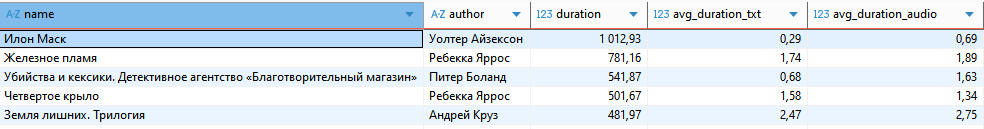

## Задание 3

Составьте топ-10 авторов по суммарной длительности чтения их книг на всех платформах, включая веб. Для каждого автора добавьте количество уникальных текстовых книг (тип контента 'Book' ) и выведите среднюю длительность прослушивания их аудиокниг только на мобильных устройствах. Исключите авторов, у которых нет аудиокниг.

**Решение:**

In [ ]:
with (select array('Букмейт Android', 'Букмейт iOS', 'Букмейт Web' )) as array_platform,
     (select array('Букмейт Android', 'Букмейт iOS' )) as array_mobile_platform
select  c.main_author_name as author,
        round(sum(au.hours),2) as duration,
        countDistinctIf(c.main_content_id, c.main_content_type='Book') as count_txt_book,
        round(avgIf(au.hours, c.main_content_type='Audiobook' and has(array_mobile_platform, au.usage_platform_ru)),2) as duration_audio
from source_db.content as c
join source_db.audition as au on au.main_content_id=c.main_content_id
where has(array_platform, au.usage_platform_ru)
group by c.main_author_name as author
having count(c.main_content_type='Audiobook') > 0
order by duration desc
limit 10;

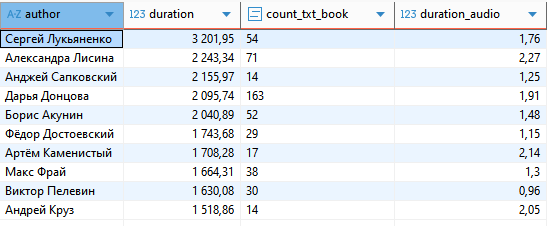

## Задание 4

### Количество пользователей в сегментах по всем платформам

У продакт-менеджера есть предположение, что среди Android-пользователей аудиокниги почти так же популярны, как тексты. А среди iOS-пользователей читателей книг вдвое больше, чем слушателей, если считать по суммарной длительности сессии.
Проверьте предположение менеджера.

Для начала выделите три сегмента пользователей:
* «Слушатель» — тот, кто преимущественно пользуется аудиокнигами. Прослушивание книг составляет 70% и выше от суммарной длительности сессий.
* «Читатель» — преимущественно пользуется текстовыми книгами. Чтение книг — от 70%.
* «Оба» — остальные пользователи сервиса.

Исключите пользователей, у которых нет сессий ни с книгами, ни с аудиокнигами, и посчитайте количество пользователей в каждом из сегментов.

**Решение:**

In [ ]:
with (select array('Букмейт Android', 'Букмейт iOS')) as array_platform
select  categ,
        count(categ) as count_categ
from   (select multiIf(round(100* sumIf(au.hours, c.main_content_type='Audiobook')/sum(au.hours),2) >= 70, 'Слушатель',
        round(100* sumIf(au.hours, c.main_content_type = 'Book')/sum(au.hours),2) >= 70, 'Читатель',
        'Оба') as categ
        from source_db.audition as au
        join source_db.content as c on au.main_content_id=c.main_content_id
        where has(array_platform, au.usage_platform_ru)
        group by au.puid) as sub_query
group by categ
order by  count_categ desc;

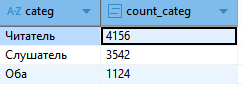

### Количество пользователей в сегментах по платформам

На основе полученных данных проверьте предположение менеджера о том, что среди пользователей Android примерно одинаковое количество читателей и слушателей, а на устройствах iOS читателей книг вдвое больше, чем слушателей. Чтобы определить основную платформу пользователя, учитывайте время её использования. Например, если пользователь посещал сервис с двух устройств: два часа на iOS и пять часов на Android, то основной платформой такого пользователя будет Android.

**Решение:**

In [ ]:
with (select array('Букмейт Android', 'Букмейт iOS')) as array_platform
select  categ,
        platform,
        count(categ) as count_categ,
        round(count_categ/sum(count_categ) over (partition by platform),2) as part_in_platform
from (select multiIf(round(100* sumIf(au.hours, c.main_content_type='Audiobook')/sum(au.hours),2) >= 70, 'Слушатель',
             round(100* sumIf(au.hours, c.main_content_type = 'Book')/sum(au.hours),2) >= 70, 'Читатель',
             'Оба') as categ,
             if( sumIf(au.hours, au.usage_platform_ru='Букмейт Android') > sumIf(au.hours, au.usage_platform_ru='Букмейт iOS') as hours_iOS, 'Android', 'iOS') as platform
      from source_db.audition as au
      join source_db.content as c on au.main_content_id=c.main_content_id
      where has(array_platform, au.usage_platform_ru)
      group by au.puid) as sub_query     
group by categ, platform
order by  count_categ  desc;

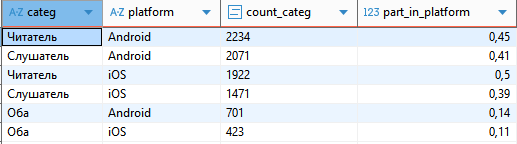

**Вывод**: предположения менеджера неверны: доля слушателей аудиокниг на всех платформах меньше, чем тех, кто читает бумажные книги.

## Задание 5

Изучите, существует ли связь между форматом использования приложения (прослушивание или чтение) и днём недели. Падает ли использование аудиокниг в выходные на всех платформах, включая веб? Чтобы это узнать, для каждого типа контента посчитайте среднее время его использования в рабочие и выходные дни и округлите до целого числа.

**Решение:**

Для всех платформ. В задании нужно округлить среднее время до целого, но получается бессмылица, оставила округление до 2 знаков.

In [ ]:
with (select array('Букмейт Android', 'Букмейт iOS', 'Букмейт Web')) as array_platform,
user_duration as (select au.puid as puid,
                         au.msk_business_dt_str,
                         if(toDayOfWeek(au.msk_business_dt_str)<6, 'Будни', 'Выходные') as day_of_week,
                         sumIf(au.hours, c.main_content_type='Audiobook') as hours_Audio,
                         sumIf(au.hours, c.main_content_type='Book') as hours_Book
                  from source_db.audition as au
                  join source_db.content as c on au.main_content_id=c.main_content_id
                  where has(array_platform, au.usage_platform_ru)
                  group by puid, au.msk_business_dt_str, main_content_type )
select  day_of_week,
        round(avg(hours_Audio),2) as avg_Audio,
        round(avg(hours_Book),2) as avg_Book
from user_duration
group by day_of_week
order by day_of_week;

In [ ]:
С округлением до целого

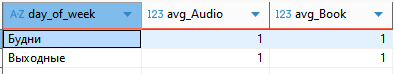

С округлением до 2-х знаков

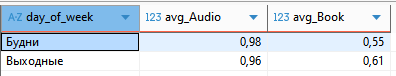

**Вывод:** в целом на всех платформах прослушивание - чуть меньше в выходные, чем в будни, а текстовый формат в выходные - дольше.

## Задание 6

Продакт-менеджер хочет отслеживать обновления приложений на Android и iOS. У него есть предположение, что больший процент пользователей iOS используют последнюю версию приложения и в целом чаще его обновляют.
Для начала изучите, у какой части пользователей на текущий момент стоят последние версии приложения на каждой из платформ. Для этого посчитайте последнюю активную версию каждого пользователя и сравните её с последней версией у каждой платформы. Для каждой платформы выведите процент пользователей с последней версией приложения и округлите его до двух знаков после точки.

**Решение:**

with (select array('Букмейт Android', 'Букмейт iOS')) as array_platform,
     (select max(app_version)
     from source_db.audition
     where has(array_platform, usage_platform_ru) and usage_platform_ru='Букмейт iOS') as last_iOS_version,
     (select max(app_version)
     from source_db.audition
     where has(array_platform, usage_platform_ru) and usage_platform_ru='Букмейт Android') as last_Android_version,
users_versions  as (select  puid,
                            usage_platform_ru,
                            msk_business_dt_str,
                            app_version,
                            row_number() over (partition by puid, usage_platform_ru  order by msk_business_dt_str desc) as rn
                    from source_db.audition
                    where has(array_platform, usage_platform_ru)
                    order by usage_platform_ru,  msk_business_dt_str )
select 
round(100* countIf(usage_platform_ru='Букмейт Android' and app_version = last_Android_version)/countIf(usage_platform_ru='Букмейт Android'),2) as Android_percent,
round(100* countIf(usage_platform_ru='Букмейт iOS' and app_version = last_iOS_version)/countIf(usage_platform_ru='Букмейт iOS'),2) as iOS_percent
from users_versions
where rn=1;


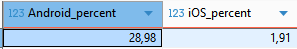

**Вывод:** Процент пользователей с поcледней версией приложения на платформах Android - выше, чем iOS.

## Задание 7

Продакт-менеджер хочет понять, как часто пользователи обновляют приложение на каждой из платформ. Фактом обновления считайте изменение версии у каждого пользователя. Представьте, что любое изменение возможно только в сторону более новой версии.
Проверьте предположение о том, что пользователи iOS чаще обновляют приложение. Посчитайте метрику update_rate, которая покажет среднюю частоту обновлений на пользователя. Округлите её до двух знаков после точки.

**Решение:**

In [ ]:
with (select array('Букмейт Android', 'Букмейт iOS')) as array_platform,
     (select max(app_version)
     from source_db.audition
     where has(array_platform, usage_platform_ru) and usage_platform_ru = 'Букмейт iOS') as last_iOS_version,
     (select max(app_version)
     from source_db.audition
     where has(array_platform, usage_platform_ru) and usage_platform_ru = 'Букмейт Android') as last_Android_version,
users_versions  as (select  puid,
                            usage_platform_ru,
                            msk_business_dt_str,
                            app_version,
                            dense_rank(app_version) over (partition by puid, usage_platform_ru order by app_version) as rank
                    from source_db.audition
                    where has(array_platform, usage_platform_ru))
select  usage_platform_ru,
        round(avg(count_user_update),2) as update_rate
from    (select puid,
                usage_platform_ru, 
                max(rank) as count_user_update
        from users_versions
        group by puid, usage_platform_ru) as sub_query
group by usage_platform_ru

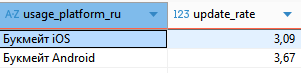

**Вывод**: Пользователи Android обновляют приложение немного чаще, чем пользователи iOS.

## Задание 8

Новая задача — у коллег есть опасения, что не все книги на тему магии верно размечены с точки зрения категорий. Считается, что у книги должно быть не больше 3–4 категорий с темами. Необходимо найти все книги на магическую тему, которые при этом не входят в художественную литературу, и проверить, правильно ли они размечены.
Начните с подсчёта книг с тегом «Магия». Выведите количество таких книг в каталоге.

**Решение:**

Варинат с arrayExists

In [ ]:
select count(main_content_id) as count_books
from source_db.content
where arrayExists(x -> positionCaseInsensitive(x, 'Магия') > 0, published_topic_title_list) and 
      arrayExists(x -> positionCaseInsensitive(x, 'Художественная литература') = 0, published_topic_title_list)

Вариант с has:

In [ ]:
select count(main_content_id) as count_books
from source_db.content
where (has(published_topic_title_list, 'Магия') or has(published_topic_title_list, 'магия')) and 
       not has(published_topic_title_list, 'Художественная литература')

Количество нехудожественных книг c тегом "Магия"/"магия" = 46.

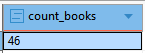

## Задание 9

Найдите все книги со словом «магия» в названии, для которых не проставлен тег «Магия». При этом не учитывайте книги с тегом «Художественная литература». Выведите количество таких книг в каталоге.

**Решение:**

В задании в названии должно быть "магия" с маленькой буквы, я сделала для всех вариантов - и с маленькой и с большой.

In [ ]:
select count(main_content_id) as count_books
from source_db.content
where (main_content_name like '%Магия%' or main_content_name like '%магия%') and
      (arrayStringConcat(published_topic_title_list,'; ') not like '%Магия%') and 
      (arrayStringConcat(published_topic_title_list,'; ') not like '%магия%') and
      (arrayStringConcat(published_topic_title_list,'; ') not like '%Художественная литература%')

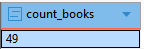

Количество нехудожественных книг со словом "Магия"/"магия" в названии без тега = 49.

## Задание 10

Посчитайте среднее количество категорий у книг с тегом «Магия» и среднее количество категорий у книг в каталоге в целом. Округлите значения до двух знаков после точки. Напомним, что коллегам важно, чтобы у каждой книги было не больше 3–4 категорий. Получится ли не превысить рекомендованного количества?

**Решение:**

In [ ]:
select 'Магические книги' as type_book,
        round(avg(length(published_topic_title_list)),2) as avg_tag
from source_db.content
where arrayExists(x -> positionCaseInsensitive(x, 'Магия') > 0, published_topic_title_list) 
union all
select 'Все книги' as type_book,
        round(avg(length(published_topic_title_list)),2) as avg_tag
from source_db.content
order by type_book

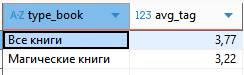

**Вывод:** Рекомендованное количество категорий для "магических" книг не превышено.

## Задание 11

Продакт-менеджер выяснил, что в приложении одной из мобильных платформ могла возникнуть проблема — длина пользовательской сессии (поле hours_sessions_long ) записывается некорректно, и это происходит как минимум в одной из стран. Чтобы найти аномалию в данных, используйте такую меру дисперсии как коэффициент вариации (коэффициент определяется как отношение стандартного отклонения к среднему). Чем выше этот показатель, тем более подозрительно с точки зрения анализа распределены данные.
Исследуйте коэффициент по странам и мобильным платформам. В какой стране и на какой платформе видна аномалия в данных? Ограничьте выборку одной страной, в которой коэффициент вариации для одной из платформ будет наибольшим.

**Решение:**

В функция вычисления стандартного отклонения - stddevPop.

In [ ]:
with (select array('Букмейт Android', 'Букмейт iOS')) as array_platform
select  usage_country_name,
        usage_platform_ru,
        round(stddevPop(hours_sessions_long)/avg(hours_sessions_long),2) as coeff_of_variation
from source_db.audition
where has(array_platform, usage_platform_ru)
group by usage_country_name, usage_platform_ru
order by coeff_of_variation desc
limit 1;

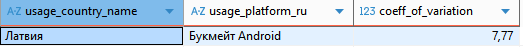

Аномалия - на платформе Android в Латвии.